In [111]:
"""

I will use MLP as soft-sensing model to predict UCE for HDPE process.
The originally collected data is insufficient enough to
build a soft sensor working well. To further improve the
soft sonsor's performance, I add a number of virtual
samples generated by my virtual sample generation model,
which is a deeply layered generative model base on CGAN (we call it RegCGAN).
In the model, CVT is employed to generate the input parts of
the virtual sample while the output parts are synthesis by
averaging the outputs sampling on RegCGAN output neurons.

"""

import importlib

from sklearn.metrics import mean_absolute_error, mean_squared_error
import dataset, metrics, plotting, config, network
from models import reg_cgan_model, mlp_model
import numpy as np
import random
from os.path import basename

importlib.reload(network)
importlib.reload(dataset)
importlib.reload(metrics)
importlib.reload(plotting)
importlib.reload(config)
importlib.reload(reg_cgan_model)
importlib.reload(mlp_model)

<module 'models.mlp_model' from '/Users/zhongsheng/Documents/GitWorkspace/RegCGAN/models/mlp_model.py'>

In [2]:
import os

dataset_config = config.DatasetConfig(scenario="hdpeuce")

assert(dataset_config.scenario == "magical_sinus"
      or dataset_config.scenario == "hdpeuce")
fig_dir = f"../figures/{dataset_config.scenario}"

try:
    os.mkdir(fig_dir)
    print(f"Directory {fig_dir} created")
except FileExistsError:
    print(f"Directory {fig_dir} already exists replacing files in this notebook")

Directory ../figures/hdpeuce already exists replacing files in this notebook


In [3]:
mlp_config = config.MLPConfig(lr=0.001, dropout_rate=0.01, epochs=10000, activation="relu", optimizer="Adam")

In [4]:
random_seed = 1992
np.random.seed(random_seed)
random.seed(random_seed)

from tensorflow import set_random_seed
set_random_seed(random_seed)

In [6]:
X_train, y_train, X_test, y_test = dataset.get_dataset(scenario=dataset_config.scenario,
                                                                         seed=random_seed)
train_data = np.c_[X_train, y_train]
test_data = np.c_[X_test, y_test]
np.savetxt(f"{fig_dir}/hdpeuce_train_data.txt", train_data, fmt=f"%.5f")
np.savetxt(f"{fig_dir}/hdpeuce_test_data.txt", test_data, fmt=f"%.5f")
np.savetxt(f"{fig_dir}/hdpeuce_y_test.txt", y_test, fmt=f"%.5f")

##  baseline: MLP trained with training samples only

In [7]:
mlp_config = config.MLPConfig(lr=0.1, dropout_rate=0.1, epochs=10000, activation="relu", optimizer="Adam")
regressor = mlp_model.MLPRegressor(mlp_config)

In [8]:
history = regressor.train(X_train, y_train, x_val=X_test, y_val=y_test, verbose=False)

In [ ]:
plotting.plot_learning_curves(history)

In [10]:
y_pred_baseline = regressor.predict(X_test)
np.savetxt(f"{fig_dir}/{basename(fig_dir)}_baseline_pred.txt", y_pred_baseline, fmt="%.5f")

In [ ]:
plotting.plot_mlp_ypred(y_test, y_pred_baseline, None, None, None, None,
                          fig_dir=fig_dir, prefix="mlp_prediction_baseline", save_fig=True)

In [12]:
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
print(f"MLP's baseline mae: {mae_baseline:.3e}")
print(f"MLP's baseline mse: {mse_baseline:.3e}")

MLP's baseline mae: 1.074e-03
MLP's baseline mse: 1.825e-06


## load CVT samples

In [14]:
cvt_data = np.load(f"{fig_dir}/{basename(fig_dir)}_cvt_samples.npy")
X_cvt, y_cvt = cvt_data[:, :-1], cvt_data[:, -1].reshape(-1, 1)

In [15]:
X_large = np.r_[X_train, X_cvt]
y_large = np.r_[y_train, y_cvt]


## MLP with new training samples

In [20]:
mlp_config = config.MLPConfig(lr=0.001, dropout_rate=0.01, epochs=10000, activation="relu", optimizer="Adam")
regressor = mlp_model.MLPRegressor(mlp_config)

In [21]:
history = regressor.train(X_large, y_large, x_val=X_test, y_val=y_test, verbose=False)

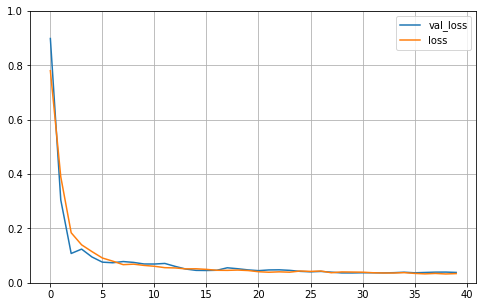

In [22]:
plotting.plot_learning_curves(history)

In [25]:
y_pred_cvt = regressor.predict(X_test)
np.savetxt(f"{fig_dir}/{basename(fig_dir)}_mlp+regcgan_pred.txt", y_pred_cvt, fmt="%.5f")

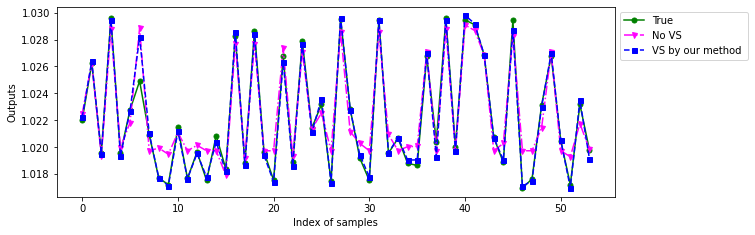

In [24]:
plotting.plot_mlp_ypred(y_test, y_pred_baseline, y_pred_cvt, None, None, None,
                          fig_dir=fig_dir, prefix="mlp_prediction_cvt", save_fig=True)

In [57]:
mae_cvt = mean_absolute_error(y_test, y_pred_cvt)
mse_cvt = mean_squared_error(y_test, y_pred_cvt)
print(f"MLP + CVT mae: {mae_cvt:.3e}")
print(f"MLP + CVT mse: {mse_cvt:.3e}")

MLP + CVT mae: 2.777e-04
MLP + CVT mse: 2.862e-07


## load Bootstrap samples

In [30]:
boot_data = np.load(f"{fig_dir}/{basename(fig_dir)}_bootstrap_samples.npy")
X_boot, y_boot = boot_data[:, :-1], boot_data[:, -1].reshape(-1, 1)

X_large = np.r_[X_train, X_boot]
y_large = np.r_[y_train, y_boot]


## train MLP with training samples + Bootstrap samples

In [31]:
mlp_config = config.MLPConfig(lr=0.001, dropout_rate=0.15, epochs=10000, activation="relu", optimizer="Adam")
regressor = mlp_model.MLPRegressor(mlp_config)

In [32]:
history = regressor.train(X_large, y_large, x_val=X_test, y_val=y_test, verbose=False)

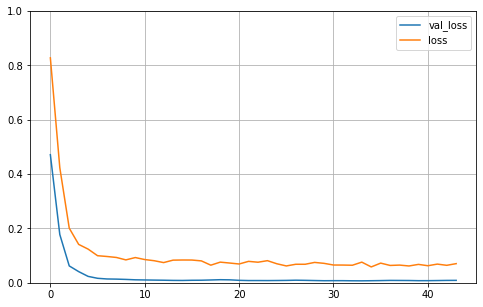

In [33]:
plotting.plot_learning_curves(history)

In [34]:
y_pred_boot = regressor.predict(X_test)
np.savetxt(f"{fig_dir}/{basename(fig_dir)}_mlp+bootstrap_pred.txt", y_pred_boot, fmt="%.5f")

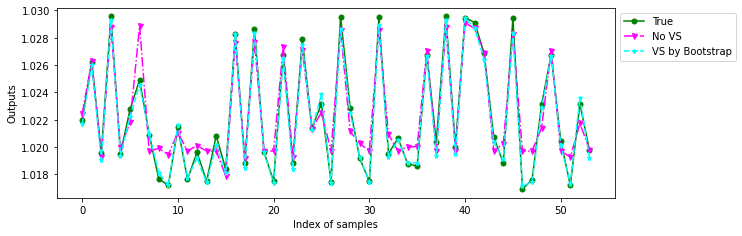

In [43]:
plotting.plot_mlp_ypred(y_test, y_pred_baseline, None, None, None, y_pred_boot,
                          fig_dir=fig_dir, prefix="mlp_prediction_bootstrap", save_fig=True)

In [44]:
mae_bootstrap = mean_absolute_error(y_test, y_pred_boot)
mse_bootstrap = mean_squared_error(y_test, y_pred_boot)
print(f"MLP + Bootstrap mae: {mae_bootstrap:.3e}")
print(f"MLP + Bootstrap mse: {mse_bootstrap:.3e}")

MLP + Bootstrap mae: 3.082e-04
MLP + Bootstrap mse: 1.526e-07


## load TTD samples

In [45]:
ttd_data = np.load(f"{fig_dir}/{basename(fig_dir)}_ttd_samples.npy")
X_ttd, y_ttd = ttd_data[:, :-1], ttd_data[:, -1].reshape(-1, 1)

X_large = np.r_[X_train, X_ttd]
y_large = np.r_[y_train, y_ttd]


## train MLP with training samples + TTD samples

In [38]:
mlp_config = config.MLPConfig(lr=0.01, dropout_rate=0.01, epochs=10000, activation="relu", optimizer="Adam")
regressor = mlp_model.MLPRegressor(mlp_config)

In [39]:
history = regressor.train(X_large, y_large, x_val=X_test, y_val=y_test, verbose=False)

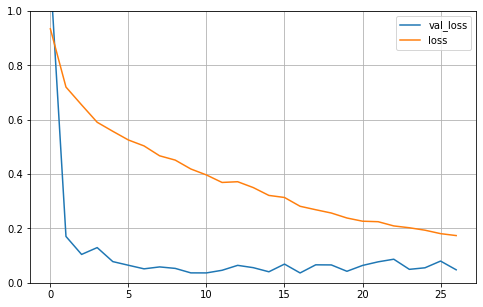

In [40]:
plotting.plot_learning_curves(history)

In [41]:
y_pred_ttd = regressor.predict(X_test)
np.savetxt(f"{fig_dir}/{basename(fig_dir)}_mlp+ttd_pred.txt", y_pred_ttd, fmt="%.5f")

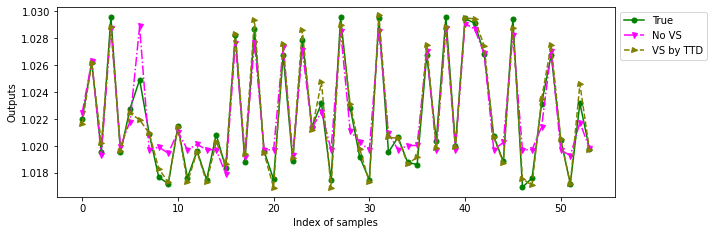

In [46]:
plotting.plot_mlp_ypred(y_test, y_pred_baseline, None, None, y_pred_ttd, None,
                          fig_dir=fig_dir, prefix="mlp_prediction_ttd", save_fig=True)

In [47]:
mae_ttd = mean_absolute_error(y_test, y_pred_ttd)
mse_ttd = mean_squared_error(y_test, y_pred_ttd)
print(f"MLP + TTD mae: {mae_ttd:.3e}")
print(f"MLP + TTD mse: {mse_ttd:.3e}")

MLP + TTD mae: 4.657e-04
MLP + TTD mse: 4.526e-07


## load MTD samples

In [48]:
mtd_data = np.load(f"{fig_dir}/{basename(fig_dir)}_mtd_samples.npy")
X_mtd, y_mtd = mtd_data[:, :-1], mtd_data[:, -1].reshape(-1, 1)


def extend_attribute(att_array):
    
    def _get_acceptable_range(att):
        minimum = np.min(att)
        maximum = np.max(att)
        sx = np.var(att)
        cl = (minimum + maximum) / 2
        nl = np.sum(att < cl)
        nu = np.sum(att >= cl)
        skew_l = nl / (nl + nu )
        skew_u = nu / (nl + nu )
        l_b = cl - skew_l * np.sqrt((-2 * sx * np.log(10e-20)) / nl)
        u_b = cl + skew_u * np.sqrt((-2 * sx * np.log(10e-20)) / nu)
    
        lb = np.where(l_b <= minimum, l_b, minimum)
        ub = np.where(u_b >= maximum, u_b, maximum)
        return lb, ub, cl

    def _get_membership(att, lb, ub, cl):
        memb = np.zeros(shape=att.shape)
        num_instance = att.shape[0]
    
        for i in range(num_instance):  #% i-th sample of attribute
            if att[i] < cl:
                memb[i] = (att[i] - lb) / (cl - lb)
            else:
                memb[i] =  (ub - att[i]) / (ub - cl)
        return memb.reshape(-1, 1)

    num_instance = att_array.shape[0]
    num_att = att_array.shape[1]
    att_extension = np.zeros(shape=(num_instance, 2*num_att))
    for i in range(num_att):
        attribution = att_array[:, i].reshape(-1, 1)
        lower_boundary, upper_boundary, center_location = _get_acceptable_range(attribution)
        membership = _get_membership(attribution, lower_boundary, upper_boundary, center_location )
        extended_att = np.hstack((attribution, membership))
        att_extension[:, 2*i:2*(i + 1)] = extended_att
    return att_extension

X_train_extended = extend_attribute(X_train)
X_test_extended = extend_attribute(X_test)

In [49]:
X_large = np.r_[X_train_extended, X_mtd]
y_large = np.r_[y_train, y_mtd]

## train MLP with training samples + MTD samples

In [50]:
mlp_config = config.MLPConfig(lr=0.001, dropout_rate=0.1, epochs=10000, activation="relu", optimizer="Adam", input_size=30)
regressor = mlp_model.MLPRegressor(mlp_config)

In [51]:
history = regressor.train(X_large, y_large, x_val=X_test_extended, y_val=y_test, verbose=False)

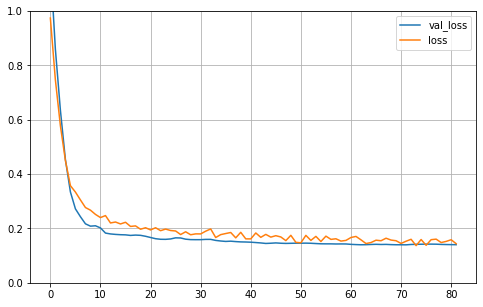

In [52]:
plotting.plot_learning_curves(history)

In [53]:
y_pred_mtd = regressor.predict(X_test_extended)
np.savetxt(f"{fig_dir}/{basename(fig_dir)}_mlp+mtd_pred.txt", y_pred_mtd, fmt="%.5f")

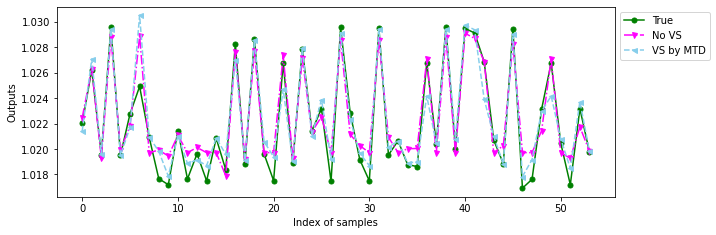

In [54]:
plotting.plot_mlp_ypred(y_test, y_pred_baseline, None, y_pred_mtd, None, None,
                          fig_dir=fig_dir, prefix="mlp_prediction_mtd", save_fig=True)

In [55]:
mae_mtd = mean_absolute_error(y_test, y_pred_mtd)
mse_mtd = mean_squared_error(y_test, y_pred_mtd)
print(f"MLP + MTD mae: {mae_mtd:.3e}")
print(f"MLP + MTD mse: {mse_mtd:.3e}")

MLP + MTD mae: 8.247e-04
MLP + MTD mse: 1.648e-06


In [58]:
file = open(f"{fig_dir}/{basename(fig_dir)}_metrics_methods_comparison.txt", "w")
file.write(f"===MAE===\n")
file.write(f"Baseline MAE test: {mae_baseline}\n")
file.write(f"Our method's MAE test: {mae_cvt}\n")
file.write(f"Bootstrap MAE test: {mae_bootstrap}\n")
file.write(f"TTD MAE test: {mae_ttd}\n")
file.write(f"MTD MAE test: {mae_mtd}\n")
file.write(f"===MSE===\n")
file.write(f"Baseline MSE test: {mse_baseline}\n")
file.write(f"Our method's MSE test: {mse_cvt}\n")
file.write(f"Bootstrap MSE test: {mse_bootstrap}\n")
file.write(f"TTD MSE test: {mse_ttd}\n")
file.write(f"MTD MSE test: {mse_mtd}\n")
file.close()


In [ ]:
import pandas as pd

dataframe = pd.read_csv(f"{fig_dir}/{basename(fig_dir)}_true_and_output.csv")

y_true = dataframe.yTrue
y_pred_baseline = dataframe.Baseline
y_pred_mtd = dataframe.MTD
y_pred_ttd = dataframe.TTD
y_pred_bootstrap = dataframe.Bootstrap
y_pred_cvt = dataframe.CVT

mse_cvt = mean_squared_error(y_true, y_pred_cvt)
mse_mtd = mean_squared_error(y_true, y_pred_mtd)
mse_ttd = mean_squared_error(y_true, y_pred_ttd)
mse_boot = mean_squared_error(y_true, y_pred_bootstrap)
mse_baseline = mean_squared_error(y_true, y_pred_baseline)


ylim = [0.992*min(y_true), 1.0008*max(y_true)]
plotting.plot_mlp_ypred(y_true, y_pred_baseline, y_pred_cvt,
                        y_pred_mtd, y_pred_ttd, y_pred_bootstrap,
                        marker_size=4,fig_width=12, fig_height=3,
                        fig_dir=fig_dir, prefix="mlp_prediction_all", ylim=ylim, save_fig=True)